In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Стандартные импорты plotly
import plotly as py
from pylab import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline()
# Устанавливаем глобальную тему 
cf.set_config_file(world_readable=True, theme='pearl', offline=True)

In [2]:
np.random.seed(123)

# Параметры
n_products = 500
start_date = '2024-04-01'
end_date = '2024-11-30'  
dates = pd.date_range(start=start_date, end=end_date, freq='D')
n_days = len(dates)

# Категории и подкатегории
categories = {
    'Куртка': ['Куртка кожаная', 'Куртка весенняя', 'Куртка зимняя'],
    'Шуба': ['Шуба искуственная', 'Шуба натуральная'],
    'Пальто': ['Пальто'],
    'Тренчкот':['Тренчкот'],
    'Пиджак':['Пиджак'],
    'Дубленка':['Дубленка авиатор','Дубленка двустороняя']
}

seasonality = {
    'Куртка кожаная':       [0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.5, 1.8, 2.2, 2.5, 2.3, 1.8],  # пик осень-зима
    'Куртка весенняя':      [1.8, 2.2, 2.5, 2.0, 1.5, 1.0, 0.8, 0.6, 0.5, 0.4, 0.5, 0.7],  # пик весна, спад летом
    'Куртка зимняя':        [0.5, 0.7, 1.0, 1.2, 1.5, 1.8, 2.0, 2.3, 2.5, 2.8, 2.5, 2.0],  # сильный зимний пик
    'Пальто':               [0.7, 0.9, 1.1, 1.3, 1.5, 1.4, 1.2, 1.0, 1.1, 1.4, 1.3, 1.0],  # умеренная сезонность
    'Тренчкот':             [0.8, 1.0, 1.3, 1.6, 1.8, 1.5, 1.2, 1.0, 1.1, 1.3, 1.2, 0.9],  # пик весна-осень
    'Пиджак':               [0.8, 1.0, 1.2, 1.5, 1.7, 1.6, 1.3, 1.1, 1.0, 1.1, 1.0, 0.8],  # плавная сезонность
    'Дубленка авиатор':     [0.4, 0.5, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.4, 2.7, 2.5, 1.9],  # зимний пик
    'Дубленка двустороняя': [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0],  # зимний пик чуть сильнее
    'Шуба искуственная':   [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0],  # зимний пик
    'Шуба натуральная':     [0.4, 0.5, 0.7, 0.9, 1.2, 1.5, 1.8, 2.1, 2.5, 2.8, 2.6, 2.0]   # зимний пик
}


# Маркетплейсы (пример)
marketplaces = ['OZ', 'WB']

# Генерируем товары с категориями, подкатегориями и маркетплейсом
products = []
for i in range(n_products):
    category = np.random.choice(list(categories.keys()))
    subcategory = np.random.choice(categories[category])
    sku = f'product_{i+1:04d}'  # 4 цифры для уникальности
    
    marketplace = np.random.choice(marketplaces)
    
    # Скидка СПП: 70% товаров в диапазоне 15-22%, 30% с 0
    discount_spp = np.random.uniform(0.15, 0.22) if np.random.rand() < 0.7 else 0.0
    
    # Платная приёмка: у 30% товаров есть сумма от 200 до 2000
    paid_reception_sum = np.random.uniform(200, 2000) if np.random.rand() < 0.3 else 0.0
    
    products.append({
        'sku': sku,
        'category': category,
        'subcategory': subcategory,
        'marketplace': marketplace,
        'discount_spp': discount_spp,
        'paid_reception_sum': paid_reception_sum
    })
products_df = pd.DataFrame(products)

# Функция генерации редких изменений цен (3 раза за период)
def generate_prices(n_days, n_changes=3, base_price=1000):
    change_points = sorted(np.random.choice(range(n_days), size=n_changes, replace=False))
    prices = []
    current_price = base_price
    idx_cp = 0
    for day in range(n_days):
        if idx_cp + 1 < n_changes and day >= change_points[idx_cp + 1]:
            idx_cp += 1
            change_factor = 1 + np.random.uniform(-0.15, 0.15)
            current_price = max(50, current_price * change_factor)
        prices.append(current_price)
    return prices

# Генерация рекламных кампаний
def generate_ad_costs(n_days):
    ad_costs = np.zeros(n_days)
    n_campaigns = np.random.randint(1, 3)
    for _ in range(n_campaigns):
        start = np.random.randint(0, n_days - 14)
        duration = np.random.randint(7, 15)
        daily_cost = np.random.uniform(500, 1500)
        ad_costs[start:start+duration] = daily_cost
    return ad_costs

all_data = []

for idx, row in products_df.iterrows():
    sku = row['sku']
    category = row['category']
    subcategory = row['subcategory']
    marketplace = row['marketplace']
    discount_spp = row['discount_spp']
    paid_reception_sum = row['paid_reception_sum']
    
    base_price = np.random.uniform(1000, 5000)
    prices = generate_prices(n_days, n_changes=3, base_price=base_price)
    
    # Получаем сезонные коэффициенты для каждого дня
    month_indices = dates.month - 1  # месяцы от 0 до 11
    seasonal_factors = np.array([seasonality[subcategory][m] for m in month_indices])
    
    # Генерация заказов с учётом сезонности (базовый лямбда = 2, умножаем на сезонный коэффициент)
    base_lambda = 2
    adjusted_lambda = base_lambda * seasonal_factors
    orders = np.random.poisson(adjusted_lambda)
    
    # Продажи и возвраты как раньше
    sales = np.array([min(o, np.random.binomial(o, 0.9)) for o in orders])
    returns = (sales * np.random.uniform(0.01, 0.05, n_days)).astype(int)
    
    # Начальный запас — зависит от сезона, чтобы запасы были выше в предсезонье
    # Средний запас умножаем на средний сезонный коэффициент за первые 7 дней периода
    initial_stock_base = np.random.randint(50, 200)
    initial_season_factor = seasonal_factors[:7].mean()
    initial_stock = int(initial_stock_base * initial_season_factor)
    
    stock = np.zeros(n_days, dtype=int)
    stock[0] = initial_stock + orders[0] - sales[0] + returns[0]
    
    for day in range(1, n_days):
        # Можно добавить небольшое сезонное влияние на поступления (orders уже сезонные)
        stock[day] = max(0, stock[day-1] + orders[day] - sales[day] + returns[day])
    
    storage_cost_per_unit = np.random.uniform(1, 5)
    storage_sum = stock * storage_cost_per_unit
    
    logistics_sum = sales * np.random.uniform(10, 50)
    
    penalties = np.zeros(n_days)
    penalty_days = np.random.choice(n_days, size=max(1, n_days // 100), replace=False)
    penalties[penalty_days] = np.random.uniform(100, 1000, size=len(penalty_days))
    
    ad_costs = generate_ad_costs(n_days)
    
    product_data = pd.DataFrame({
        'date': dates,
        'sku': sku,
        'subject': category,
        'subcategory': subcategory,
        'marketplace': marketplace,
        'spp': discount_spp,
        'paid_reception_sum': paid_reception_sum,
        'orders': orders,
        'sales_count': sales,
        'return_count': returns,
        'price': prices,
        'storage_sum': storage_sum,
        'logistics_sum': logistics_sum,
        'penalties_sum': penalties,
        'ad_cost_sum': ad_costs,
        'stock': stock
    })
    
    all_data.append(product_data)

df = pd.concat(all_data).reset_index(drop=True)

In [4]:
df.sample(10)

,date,sku,subject,subcategory,marketplace,spp,paid_reception_sum,orders,sales_count,return_count,price,storage_sum,logistics_sum,penalties_sum,ad_cost_sum,stock
8140,2024-06-28,product_0034,Дубленка,Дубленка двустороняя,WB,0.185660,0.000000,5,4,0,3826.691702,151.742810,45.122232,0.000000,0.0,78
45385,2024-04-02,product_0187,Тренчкот,Тренчкот,WB,0.203428,0.000000,8,7,0,1915.248210,240.073571,162.560967,0.000000,0.0,156
88804,2024-11-19,product_0364,Шуба,Шуба натуральная,OZ,0.000000,0.000000,5,5,0,1228.525838,470.911869,178.601384,0.000000,0.0,178
99153,2024-06-29,product_0407,Шуба,Шуба натуральная,OZ,0.168119,0.000000,1,1,0,2615.467794,895.424506,23.955161,0.000000,0.0,199
44624,2024-11-03,product_0183,Тренчкот,Тренчкот,WB,0.157015,0.000000,1,1,0,3980.651126,1423.009865,40.668054,0.000000,0.0,329
88870,2024-05-25,product_0365,Шуба,Шуба искуственная,OZ,0.196679,0.000000,0,0,0,2486.151427,125.266183,0.000000,0.000000,0.0,54
97870,2024-04-27,product_0402,Тренчкот,Тренчкот,OZ,0.164231,1155.470937,1,1,0,2665.654532,250.316006,11.492697,0.000000,0.0,115
75693,2024-05-24,product_0311,Тренчкот,Тренчкот,WB,0.000000,616.341894,9,8,0,2942.302060,581.844103,293.075105,0.000000,0.0,265
92010,2024-04-23,product_0378,Пальто,Пальто,WB,0.184488,1751.257183,0,0,0,1865.872158,97.007801,0.000000,562.905546,0.0,74
59904,2024-08-03,product_0246,Шуба,Шуба натуральная,WB,0.214539,1993.824436,8,8,0,2683.642167,251.230621,319.138905,0.000000,0.0,113


In [63]:
# Предрасчёты для временных рядов

df['sales_with_return'] = df['sales_count'] - df['return_count']
df['price_spp'] = df.apply(lambda row: row['price']*row['spp'], axis=1)
df['sales'] = df['price']*df['sales_count']
df['return'] = df['price']*df['return_count']
df['sales_spp'] = df['price_spp']*df['sales_count']
df['return_spp'] = df['price_spp']*df['return_count']
df['real_commission'] = df['spp'].apply(lambda x: (0.25 - x))
df['revenue'] = df['sales_with_return']*df['price']
df['revenue_spp'] = df['sales_with_return']*df['price_spp']

df['week'] = df['date'].apply(lambda d: d.week)

In [180]:
df_gr = df[df['subcategory']=='Тренчкот'].groupby(['date'])[['sales_with_return']].sum() # \/


def visa(data, metric):
    data.iplot(y=metric,kind='line',xTitle='date', yTitle=metric)

visa(df_gr, 'sales_with_return')

In [181]:
# Проверка стационарности продаж
result = adfuller(df_gr)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')


ADF Statistic: -1.3146
p-value: 0.6225


In [238]:
df_gr_diff = df_gr.diff().dropna()
# df_gr_diff = np.log(df_gr)

df_gr.iplot(y='sales_with_return',kind='line',xTitle='date', yTitle='sales_with_return')

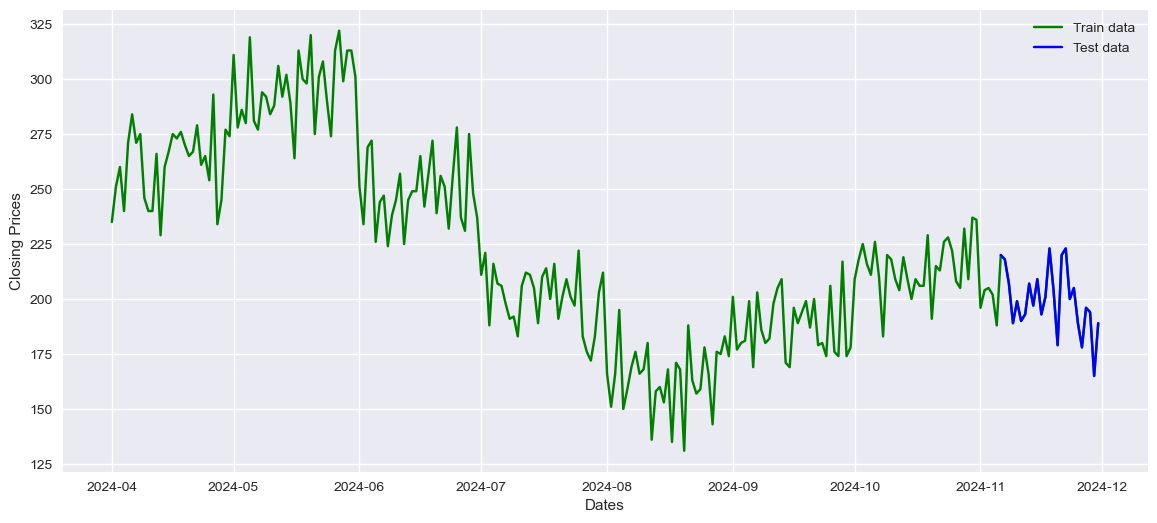

In [239]:
train_data, test_data = df_gr[3:int(len(df_gr)*0.9)], df_gr[int(len(df_gr)*0.9):]

plt.figure(figsize=(14,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_gr, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

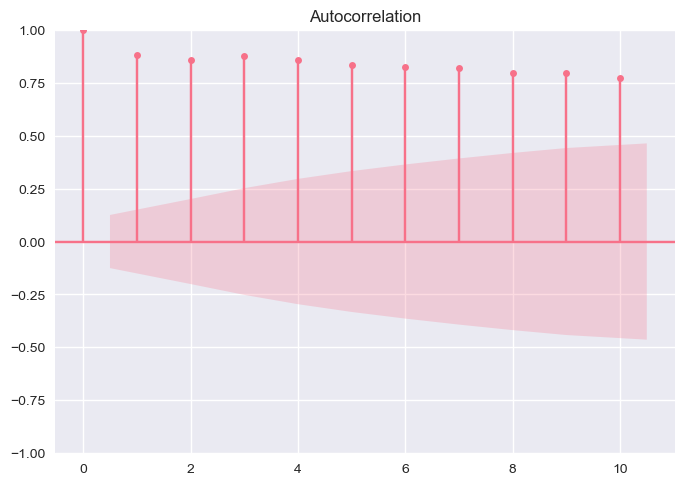

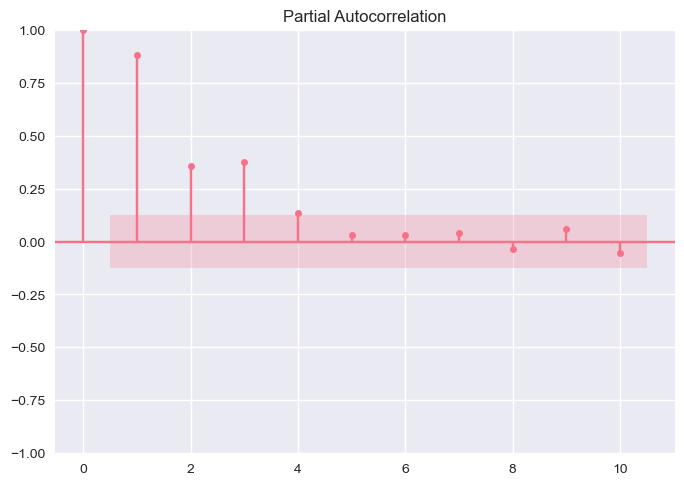

In [240]:
# Строим графики автокорреляции (ACF) и частичной автокорреляции (PACF) для определения p и q
plot_acf(df_gr, lags=10)
plot_pacf(df_gr, lags=10)
plt.show()


# q = 13
# p = 3

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1928.097, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1890.136, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1852.090, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1926.125, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1854.089, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1854.089, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1854.114, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1850.557, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1852.556, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1852.555, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1888.217, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1852.598, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.636 seconds
                               SARIMAX Results                                
Dep. Vari

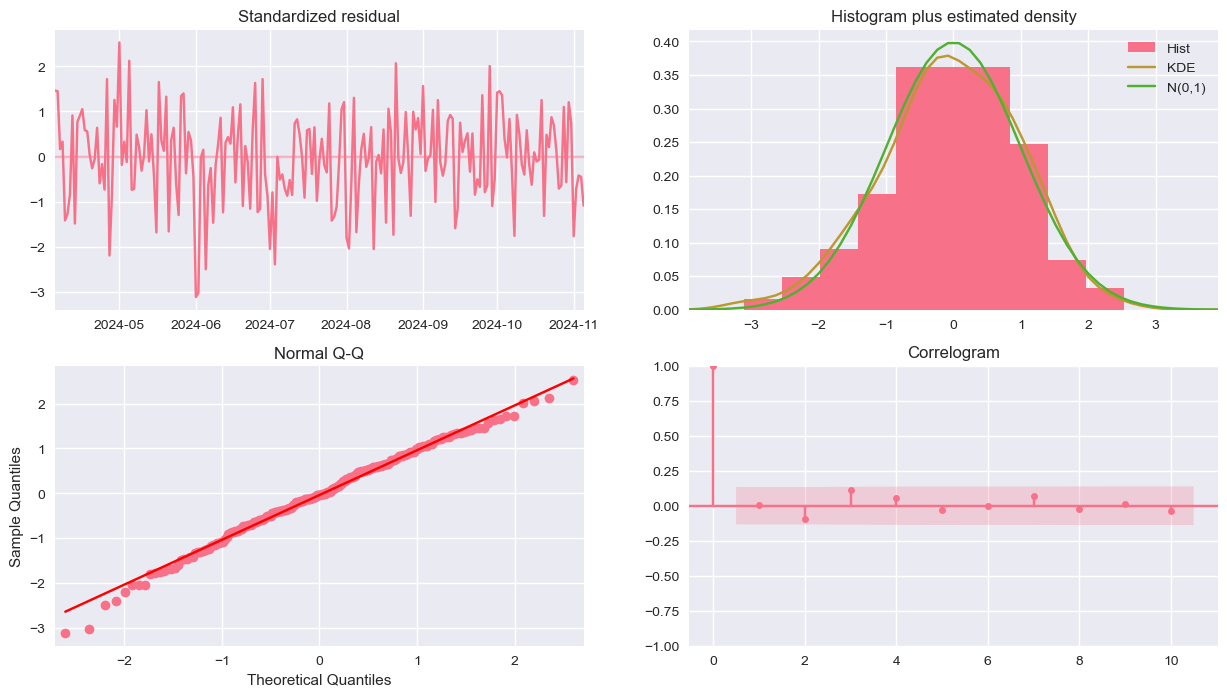

Лучшие параметры: ARIMA(0, 1, 1)


In [241]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

print(f'Лучшие параметры: ARIMA{model_autoARIMA.order}')

In [245]:
p, d, q = 3, 1, 2


# Обучаем модель ARIMA
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      sales_with_return   No. Observations:                  216
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -920.395
Date:                 Пт, 30 май 2025   AIC                           1852.789
Time:                        20:55:06   BIC                           1873.013
Sample:                    04-04-2024   HQIC                          1860.961
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3683     32.093     -0.011      0.991     -63.270      62.533
ar.L2         -0.2726      6.927     -0.039      0.969     -13.849      13.304
ar.L3         -0.0347      7.821     -0.004      0.9

In [246]:
# Делаем прогноз на 30 дней вперёд
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

mae = mean_absolute_error(test_data, forecast)
print(f'MAE: {mae:.2f}')

MAE: 11.30


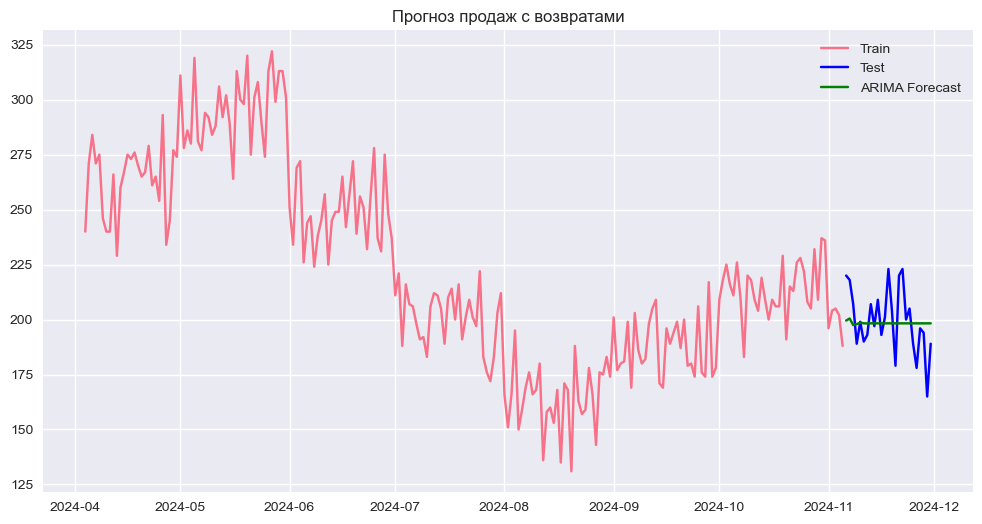

In [247]:
# Визуализируем результаты прогноза и реальных значений
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test',color='blue')
plt.plot(test_data.index, forecast, label='ARIMA Forecast',color='green')
plt.title('Прогноз продаж с возвратами')
plt.legend()
plt.show()
